# Tweet sentiment analysis

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import cufflinks as cf
import plotly
import plotly.graph_objs as go
import datetime
import boto3
import s3fs
pd.set_option('display.max_colwidth', -1)
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

## Get dataframe from S3 bucket
Iterates over all objects in the tweet-object folder in the aws s3 bucket.
The objects are retrieved in JSON format and converted to a Pandas dataframe.

In [2]:
# # Read CSV file
# #tweets_today = pd.read_csv(r'..\datasets\raw_data\tweets{}.csv'.format(datetime.date.today()))
# tweets_today = pd.read_csv(r'..\datasets\raw_data\tweets2019-10-08.csv')
# tweets_today = tweets_today.head(5000)
# # Gets tweet texts
# tweets_today_text = tweets_today['tweet']
bucketname = 'ops-vw-interns-climate-perception-tweets'
dataframe = pd.DataFrame(columns=('creation date','keyword', 'tweet', 
                                  'username'))
s3 = boto3.resource('s3')

s3_tweets = s3.Bucket(bucketname).objects.filter(Prefix='tweet-objects/', Delimiter='/').all()
for file in s3_tweets:
    temp_df = pd.read_json('s3://{}/{}'.format(bucketname, file.key))
    dataframe = dataframe.append(temp_df, sort=False, ignore_index=True)
dataframe_tweets = dataframe['tweet']
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63851 entries, 0 to 63850
Data columns (total 4 columns):
creation date    63851 non-null object
keyword          63851 non-null object
tweet            63851 non-null object
username         63851 non-null object
dtypes: object(4)
memory usage: 1.9+ MB


## Data cleaning
Removing unneeded characters from the tweet texts like hashtags and urls

In [3]:
# Preprocessing of tweet texts
def format_tweet(tweet):
    processed_tweet=''
    for word in tweet.split():
        # Removing URL from tweet
        processed_word = re.sub('([^0-9A-Za-z \t])|(\w+:\/\/\S+)', ' ', word)
        
        # remove all single characters
        processed_word = re.sub('\s+[a-zA-Z]\s+', ' ', processed_word)
        
        # Remove single characters from the start
        processed_word = re.sub('\^[a-zA-Z]\s+', ' ', processed_word) 
        
        # Substituting multiple spaces with single space
        processed_word = re.sub('\s+', '', processed_word, flags=re.I)
        
        # Removing prefixed 'b'
        processed_word = re.sub('^b\s+', ' ', processed_word)
        
        # Removing &amp
        processed_word = re.sub('&amp', '&', processed_word)
        
        # Removing breaks
        processed_word = re.sub('<br/>', '', processed_word)
        
        # converts to lower
        processed_word = processed_word.lower()
        processed_tweet= processed_tweet+' '+processed_word
    return processed_tweet        
    
tweets_text = [format_tweet(tweet) for tweet in dataframe_tweets]
print('unprocessed tweet: \n'+ dataframe['tweet'][15])
print('\nprocessed tweet: \n' + tweets_text[15])

unprocessed tweet: 
AOC: My ‘Dreams of Motherhood Now Bittersweet’ Because of Global Warming https://t.co/uUIM3uSbTi https://t.co/WFLq78IywX

processed tweet: 
 aoc my dreams of motherhood now bittersweet because of global warming  


## Labeling tweets with NLTK vader
Provides te dataframe of the needed 'label' / 'target' column. In our case this column contains the sentiment values (Positive, Neutral, Negative)

In [4]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ViMs\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

The NLTK.vader library helps us label the tweets by giving the tweet text a positive, neutral and negative score. Based on those scores it calculates the 'compound' / 'total' score. This is the value that gets stored in the dataframe 

In [9]:
sid = SentimentIntensityAnalyzer()

for i, tweet in enumerate(tweets_text[50:55]):
    print('{0}:{1} \n{2}\n\n'.format(i+1, tweet, sid.polarity_scores(tweet)))

1: climate change evidence how do we know gt vital signs of the planet global climate change and global warming how do we know its happening heres the evidence  
{'neg': 0.0, 'neu': 0.809, 'pos': 0.191, 'compound': 0.5994}


2: the election debate is over stay on the track libs mistakes in four years must not be hidden apologized snc lavalin climate change vs pipeline international relations economy down huge deficit list goes on never repeated libs must go say no to libs vote no  
{'neg': 0.219, 'neu': 0.738, 'pos': 0.044, 'compound': -0.8054}


3: revealed google made large contributions to climate change deniers  
{'neg': 0.208, 'neu': 0.792, 'pos': 0.0, 'compound': -0.2732}


4: climate change the devastating effect plastics have on our oceans dwindling numbers of rare species nah  
{'neg': 0.289, 'neu': 0.711, 'pos': 0.0, 'compound': -0.6908}


5: pieces of junk toplevel japanese climate scientist rejects global warming panic  opinion  lifesite  
{'neg': 0.359, 'neu': 0.552, 'pos'

In [59]:
# Creates the text labels for the dataframe
def get_sentiment(polarity):
    if polarity < 0:
        return 'negative'
    if polarity > 0:
        return 'positive'
    else:
        return 'neutral'

word_count = [len(tweet.split()) for tweet in tweets_text]

polarity_tweets = [round(sid.polarity_scores(tweet)['compound'], 2)
                   for tweet in tweets_text]

sentiment_tweets = [get_sentiment(polarity) for polarity in polarity_tweets]

zipped_list = list(zip(sentiment_tweets, polarity_tweets,
                       tweets_text, word_count, dataframe['keyword'],
                       dataframe['username'], dataframe['creation date']))


# Store to new dataframe with sentiment values and polarities
sentiment_df = pd.DataFrame(zipped_list, 
                            columns=['Sentiment', 'Polarity', 
                                     'Tweet', 'Word count', 'Keyword', 'Username', 
                                     'Creation Date'])
sentiment_df.sample(15)

Sentiment  Polarity  \
4589   negative -0.38       
58337  negative -0.17       
34820  positive  0.71       
15999  positive  0.76       
33145  positive  0.50       
7887   positive  0.78       
44541  negative -0.78       
33785  negative -0.89       
48228  positive  0.44       
19777  positive  0.84       
37699  positive  0.23       
26147  positive  0.18       
42484  negative -0.23       
5214   positive  0.79       
48760  negative -0.69       

                                                                                                                                                                                                                                                                               Tweet  \
4589    sorry this is nuts these spaces should be enclosed facing unbearable heat qatar has begun to aircondition the outdoors                                                                                                                                                         
58337   newsweek relied on samps robin verble fire expert to explain how our ecosystem climate change and environmental issues are intensifying the spread of these fires missourisandt why are the california wildfires so intense right now                                          
34820   if you are observant you can see climate change today if you also care about tomorrow you can ask your member of congress and senators to support this                                                                                                                         
15999   world earth planet climate change prayer climate praying activism planet earth eco friendly xr climate strike extinction rebellion climate emergency act now damien weighill climate march save our planet peaceful protest                                                    
33145   they dont even bother to hide it anymore thanks cbc                                                                                                                                                                                                                            
7887    wow rained all night amp early today with high winds some tornadoes in the county north of me but now a little sun is peeking through survived another climate change                                                                                                          
44541   the climate has changed last night i was afraid to sleep under a window and packed a go bag frustration no ones making small changes or supporting big changes to reduce air pollutionclimate change keep buying those suvs and killing us                                     
33785   i said it before and i will say it again climate politics is class war their taxations and so on as a means to fight climate change is a fight against the poor the working class and everyone who is not socially on the top                                                  
48228   despite emerging from a drought and scheduling controlled power outages the state of california is still burning its time to actonclimate to keep communities safe fridaysforfuture                                                                                            
19777   this jfk inspired quote is perfect for describing the effects of climate change we are all affected by climate change and we are all capable of making changes in our lives to do something about it all of us can make a difference     jfk envionment quote earth            
37699   people should be blaming jerry brown too for your power being shut off he vetoed a bill in 2016 that would have made power companies put their lines underground then you all voted jerry brown 20 gavin newsom great going people                                             
26147   marching trump accompliment of weighs lifting us embassy moves that deny climate change the champ ko                                                                         

In [60]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63851 entries, 0 to 63850
Data columns (total 7 columns):
Sentiment        63851 non-null object
Polarity         63851 non-null float64
Tweet            63851 non-null object
Word count       63851 non-null int64
Keyword          63851 non-null object
Username         63851 non-null object
Creation Date    63851 non-null object
dtypes: float64(1), int64(1), object(5)
memory usage: 3.4+ MB


## Filtering out bad rows

In [72]:
# count =0
# for index, row in sentiment_df.iterrows():
#     if "climate change" not in row.Tweet and 'global warming' not in row.Tweet:
#         print(str(index) + text +"\n")
#         sentiment_df.drop(index,axis=0, inplace=True)
#         count += 1
# print('Deleted {} rows from the dataframe.'.format(count))

#test_df = sentiment_df[sentiment_df['Tweet'].str.contains(sentiment_df['Keyword'].str.lower())]
# sentiment_df.drop(index_remove_rows, axis = 0, inplace=True)
# sentiment_df.sample(15)

sentiment_df = sentiment_df[sentiment_df.apply(lambda row: row.Keyword.lower() in row.Tweet, axis=1)]
sentiment_df.sample(20)

Sentiment  Polarity  \
41475  negative -0.30       
56806  positive  0.19       
2258   positive  0.60       
48905  negative -0.08       
24378  positive  0.84       
52568  negative -0.04       
29747  neutral   0.00       
30431  neutral   0.00       
54522  neutral   0.00       
52311  neutral   0.00       
52617  positive  0.12       
62710  positive  0.71       
2887   positive  0.75       
40211  positive  0.60       
8546   negative -0.13       
45941  positive  0.10       
47498  positive  0.84       
48861  positive  0.68       
30082  negative -0.17       
55462  negative -0.64       

                                                                                                                                                                                                                                                                                 Tweet  \
41475   with joebiden the fossil fuel companies will continue to get subsides with your tax dollars there will be no green new deal climate change will not be addressed                                                                                                                 
56806   nelson sewankambo reflects on planetary health in africa the continent contributes least to climate change but suffers most addressing ph requires action in three areas 1 population growth 2 demand for natural resources amp ecosystems 3 urbanisation grandchallenges2019    
2258    experience sequoia national park from santa monica participate in a unique vr experience on 1020 followed by a discussion about climate change and its effect on these beautiful trees                                                                                           
48905   climate changethe facts by paul homewood i have been asked by a couple of people to produce a simple climate change factsheet and it might be worth bookmarking for future use i have kept it simple with no graphs or references as those familiar w                            
24378   we in super excited to be part of the tribecafilmins ryotfilms and idfa climate change focused pitch competition                                                                                                                                                                 
52568   7 years ago superstorm sandy devastated our state but we are more resilient now than ever before as storms become worse with climate change new york state is leading the nation to combat climate change and treat our environment as the precious resource it is               
29747   climate change and the agribusiness footprint  from loislross  climatecrisis agriculture                                                                                                                                                                                         
30431   climate change is increasing extreme weather patterns due to prolonged periods of high temperatures climatechnageisreal uncclearn                                                                                                                                                
54522   regenerative agriculture is not a buzz word its how we fight climate change and ensure a sustainable future for us all nofarmsnofoodnofuture                                                                                                                                     
52311   cdc whistleblower says he was told not to use phrase climate change after president trump was elected                                                                                                                                                                            
52617   climate change isnt just a natural phenomenon it is mostly caused by capitalism if we dont demand a more equitable earthfriendly economic system climate change will win capitalists will fight us all the way                                                                   
62710   lets

In [73]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39952 entries, 0 to 63849
Data columns (total 7 columns):
Sentiment        39952 non-null object
Polarity         39952 non-null float64
Tweet            39952 non-null object
Word count       39952 non-null int64
Keyword          39952 non-null object
Username         39952 non-null object
Creation Date    39952 non-null object
dtypes: float64(1), int64(1), object(5)
memory usage: 2.4+ MB


In [14]:
print('5 most negative tweets: \n')
top5_negative = pd.DataFrame(sentiment_df.sort_values('Polarity')[['Tweet','Polarity']].head(5))
top5_negative

5 most negative tweets: 



Tweet  \
3882    this is literally worse than isis terrorism racism homophobia sexism cancer global warming poverty world hunger israel war drug addiction the prison system police animal abuse pollution murder sexual abuse violence zionism depression mass shootings                          
57662   she is such an idiot its really sad if she believes this but even worse if she knows shes being a manipulating pos climate change didnt shut down power in cali to kill people and ruin food blame gov traitors and shitty power companies america only has a short time left     
22660   capitalism is murder cyberbullying is murder minimum wage is murder billionaires existing is murder homicide is murder global warming is murder a group of crows is murder angela lansbury is murder she wrote                                                                    
10416   snap the hell out of it people border crisis not working climate change failing gun confiscation failing oh so lets jump on the period crisis really if you fall for this one and participate in any way you really are a lost brain deadwashed person                            
38736   yes the unthinkable betrayal of the kurds separating children from parents at the border destroying family farms with stupid trade wars increasing the federal deficit pulling out of climate change pact only a few of the unthinkably stupid and careless acts of this moron    

       Polarity  
3882  -0.99      
57662 -0.99      
22660 -0.99      
10416 -0.98      
38736 -0.98

In [15]:
print('5 most positive tweets: \n')
top5_positive = sentiment_df.sort_values('Polarity', ascending=False)[['Tweet', 'Polarity']].head(5)
top5_positive

5 most positive tweets: 



Tweet  \
39530   happy diwali to all have fun have great food enjoy also dont forget that climate change is a real concern be safe and try your best to keep it environment friendly keep the animals safe its a festival for everyone lets not steal their freedom                                  
41177   success takes many shapes and forms it can be a successful career your efforts to fight global warming writing a great book helping the homeless etc thrive success inspiration talent motivation                                                                                   
57078   rate yourself looks 610 but with good lighting and a fresh trim 61510 creativity 510 after i get my spinach 10010 health 610 empathy 710 intelligence 810 trustworthiness 810 social skills710 patience 510 humor 1010 optimism 410  cause global warming  me                       
26668   in ww2 the government rose taxes and kept wages down but the rich made big profits on armaments to fight climate change the rich are going to lose out on selling coal and oil they are prepared to chance the great famine to protect their wealth they will eat while you stave   
14754   greswoldschool well done year 5 for the brilliant harvest festival assembly great message about climate change and doing our bit to save the planet super singing too very inspiring                                                                                                

       Polarity  
39530  0.98      
41177  0.98      
57078  0.98      
26668  0.98      
14754  0.97

## Data visualisation

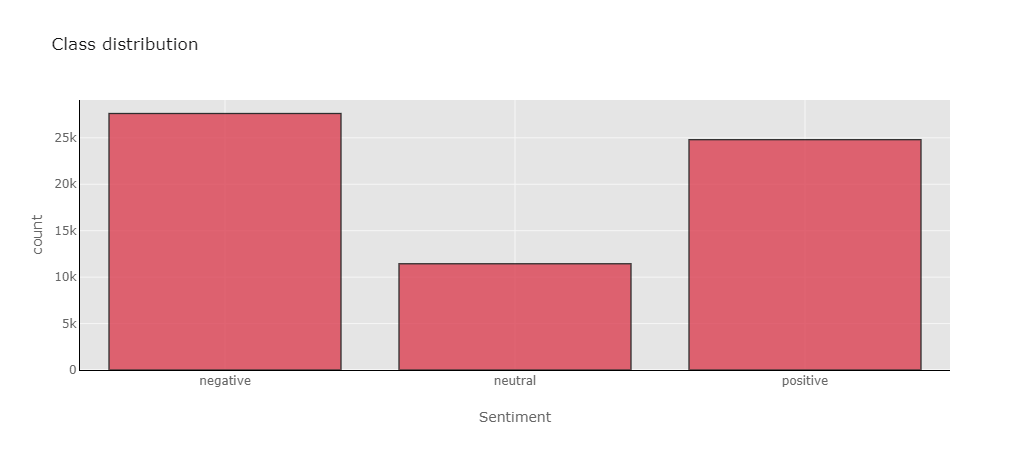

In [18]:
colors = ['red', 'yellow', 'green']
sentiment_df['Sentiment'].iplot(
    kind='hist',
    linecolor='black',
    theme='ggplot',
    colors = colors,
    xTitle='Sentiment',
    yTitle='count',
    title='Class distribution')

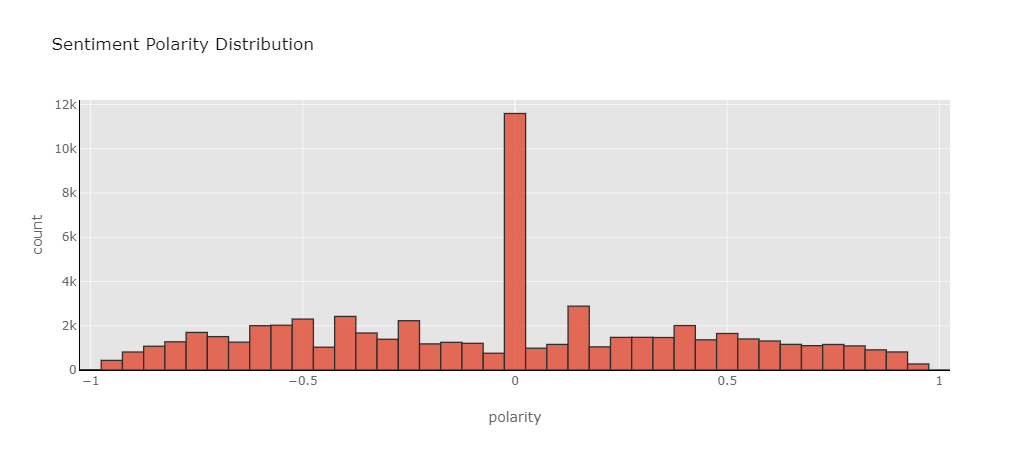

In [19]:
sentiment_df['Polarity'].iplot(
    kind='hist',
    bins=75,
    linecolor='black',
    theme='ggplot',
    xTitle='polarity',
    yTitle='count',
    title='Sentiment Polarity Distribution')
plt.show()

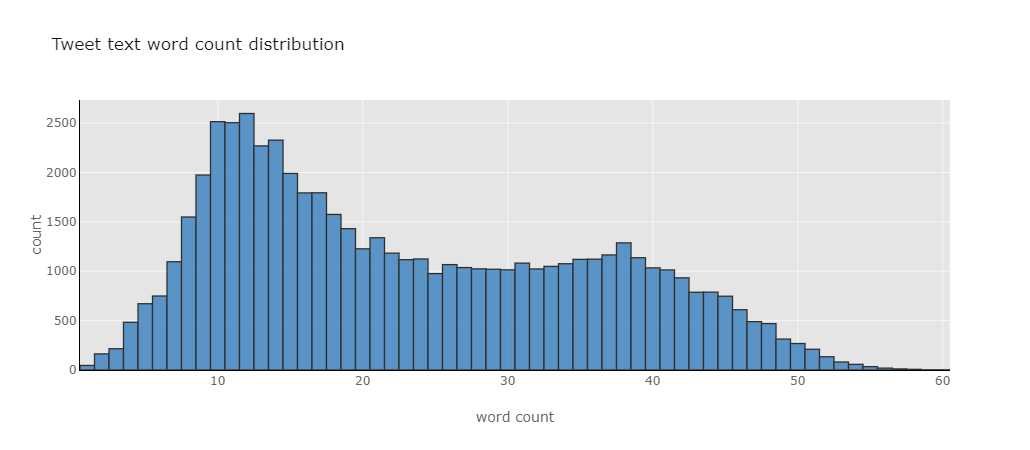

In [150]:
sentiment_df['Word count'].iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    colors='blue',
    theme="ggplot",
    yTitle='count',
    title='Tweet text word count distribution')

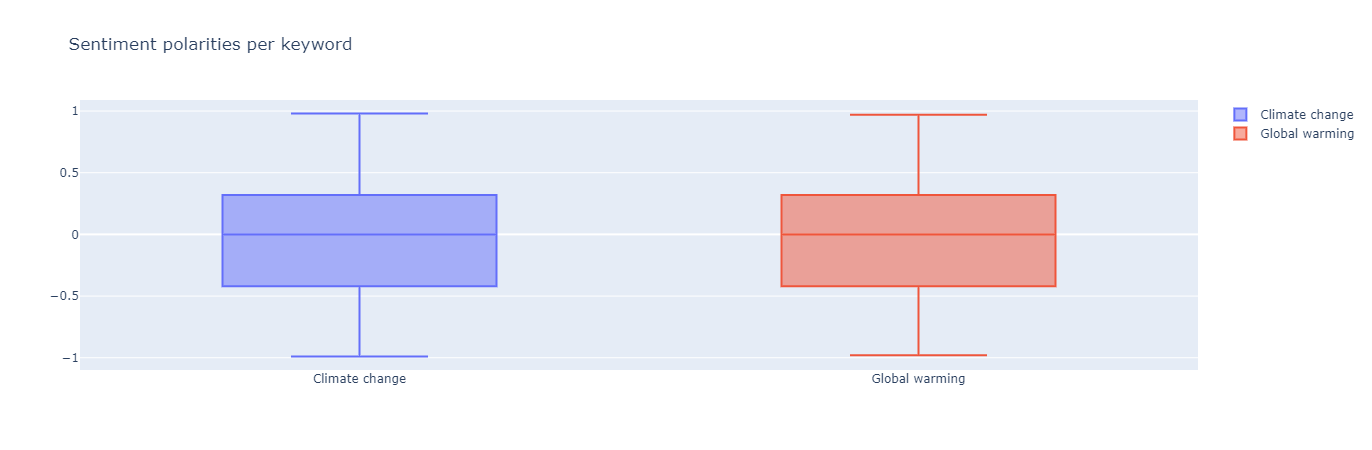

In [74]:
CC_polarities = sentiment_df[sentiment_df['Keyword']=='Climate change']['Polarity']
GW_polarities = sentiment_df[sentiment_df['Keyword']=='Global warming']['Polarity']

boxplot = go.Figure()
boxplot.add_trace(go.Box(y=CC_polarities, name = 'Climate change'))
boxplot.add_trace(go.Box(y=GW_polarities, name = 'Global warming'))

boxplot.update_layout(title_text='Sentiment polarities per keyword')
boxplot.show()

## Implementing machine learning classifiers

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import nltk
from nltk.stem import PorterStemmer
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
from yellowbrick.target import ClassBalance
from yellowbrick.features.pca import PCADecomposition

### Divide into training and test sets
We create our feature and label sets for training and testing using sklearn's train_test_split. 80% of the data will go to training sets and 20% will go to the testing sets. The method shuffles the data in a random order to make sure the sets are not unbalanced.

In [14]:
from sklearn.model_selection import train_test_split

# Extract features from df
features = sentiment_df['Tweet']

# Extract labels from df
labels = sentiment_df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels, test_size=0.2,
                                                    random_state=1)

print('Training set contains: '+str(len(X_train))+ ' samples')
print('Testing set contains: '+str(len(X_test))+ ' samples')

Training set contains: 45952 samples
Testing set contains: 11489 samples


### Preparing pipeline variables
Setup of tokenizers (converting 1 text object to a list of text objects)
and vectorizers

In [16]:
count_vec = CountVectorizer(strip_accents=None, lowercase=False, 
                            preprocessor = None)
tfidf = TfidfTransformer()

def tokenizer(text):
    return text.split()

porter = PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

#### Testing tokenizers

In [17]:
sample_tweet = 'Hi i think global warming is awesome. What about you?'

token_list = tokenizer(sample_tweet)

porter_list =tokenizer_porter(sample_tweet)

In [18]:
count_vec.fit(token_list)
print('With normal tokenizer:')
count_vec.vocabulary_

With normal tokenizer:


{'Hi': 0,
 'think': 6,
 'global': 4,
 'warming': 7,
 'is': 5,
 'awesome': 3,
 'What': 1,
 'about': 2,
 'you': 8}

In [19]:
count_vec.fit(porter_list)
print('With porter tokenizer (stemmer):')
count_vec.vocabulary_

With porter tokenizer (stemmer):


{'Hi': 0,
 'think': 5,
 'global': 3,
 'warm': 6,
 'is': 4,
 'awesome': 2,
 'what': 7,
 'about': 1,
 'you': 8}

In [20]:
from sklearn.linear_model import LogisticRegression

In [ ]:
import warnings
warnings.filterwarnings('ignore')

lr_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf), 
                        ('clf', LogisticRegression(random_state=1))])

param_grid_lr ={
                'vect__ngram_range': [(1,1),(1,2)],
                'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                 'tfidf__use_idf': [True, False],
                 'tfidf__norm': ['l1', 'l2'],
    
                'clf__dual': [True, False],
                'clf__tol': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2 ],
                'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'clf__fit_intercept': [True, False],
                'clf__max_iter' : [100, 110, 120, 130, 140],
                'clf__warm_start': [True, False]
              }
grid_lr = RandomizedSearchCV(lr_pipeline, param_grid_lr, n_iter=50,
                             verbose=10, cv=5, n_jobs=-1, scoring='accuracy')
grid_lr.fit(X_train, y_train)
print()

Fitting 7 folds for each of 150 candidates, totalling 1050 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  5.3min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 20.6min


In [22]:
print('Best parameters: ', grid_lr.best_params_)

#Create classifier based on best parameters
lr = grid_lr.best_estimator_

#Fit the data and predict the classes
lr.fit(X_train, y_train)
predictions_lr = lr.predict(X_test)

print('\nThe Logistic Regression classifier has reached an accuracy of: {:.2f}% \n'
      .format(lr.score(X_test, y_test)*100))

Best parameters:  {'vect__tokenizer': <function tokenizer at 0x0000022F6E1DBD08>, 'vect__ngram_range': (1, 1), 'tfidf__use_idf': False, 'tfidf__norm': 'l2', 'clf__warm_start': False, 'clf__tol': 1e-05, 'clf__max_iter': 120, 'clf__fit_intercept': True, 'clf__dual': False, 'clf__C': 100}

The Logistic Regression classifier has reached an accuracy of: 86.51% 



### Implementing Multinomial Naive Bayes
Based on Bayes theorem. Predicts the probability of an output based on combination of given input parameters

In [25]:
from sklearn.naive_bayes import MultinomialNB

In [34]:
mnb_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf), 
                         ('clf', MultinomialNB())])

param_grid_mnb = {
                  'vect__ngram_range': [(1,1), (1,2), (1,3)],
                  'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                  'tfidf__use_idf': [True, False],
                  'tfidf__norm': ['l1', 'l2'],
    
                  'clf__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                  'clf__fit_prior': [True, False]
                 }
grid_mnb = RandomizedSearchCV(mnb_pipeline, param_grid_mnb, n_iter=50,
                              cv=5, verbose=10, n_jobs=-1, scoring='accuracy')
grid_mnb.fit(X_train, y_train)
print()

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed:  1.8min remaining:   20.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.4min finished


In [35]:
print('Best parameters: ',grid_mnb.best_params_)

#Create classifier based on best parameters
mnb = grid_mnb.best_estimator_

#Fit the data and predict the classes
mnb.fit(X_train, y_train)
predictions_mnb = mnb.predict(X_test)

print('\nThe Multinomial Naive Bayes classifier has reached an accuracy of: {:.2f}% \n'
      .format(mnb.score(X_test, y_test)*100))

Best parameters:  {'vect__tokenizer': <function tokenizer at 0x0000022F82B276A8>, 'vect__ngram_range': (1, 1), 'tfidf__use_idf': True, 'tfidf__norm': 'l2', 'clf__fit_prior': False, 'clf__alpha': 0.01}

The Multinomial Naive Bayes classifier has reached an accuracy of: 74.66% 



### Implementing Support Vector Machine

In [26]:
from sklearn.svm import SVC

In [ ]:
svc_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf),
                         ('clf', SVC(random_state=1))])

param_grid_svm = {
                  'vect__ngram_range': [(1,1),(1,2)],
                  'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                  'tfidf__use_idf': [True, False],
                  'tfidf__norm': ['l1', 'l2'],                  
    
                  'clf__C': [0.1, 1, 10, 100],
                  'clf__kernel': ['linear', 'rbf', 'poly'],
                  'clf__gamma': [0.1, 1, 10, 100],
                  'clf__degree': [0, 1, 2, 3, 4, 5, 6]
                 }

grid_svc = RandomizedSearchCV(svc_pipeline, param_grid_svm, n_iter=50, 
                              cv=5, verbose=10, n_jobs=-1, scoring='accuracy')
grid_svc.fit(X_train, y_train)
print()

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 256.2min


In [ ]:
print('Best parameters: ', grid_svc.best_params_)
#Create classifier based on best parameters
svm = grid_svc.best_estimator_

#Fit the data and predict the classes
svm_fit = svm.fit(X_train, y_train)
predictions_svm = svm.predict(X_test)

print('\nThe Support Vector classifier has reached an accuracy of: {:.2f}% \n'
      .format(svm.score(X_test, y_test)*100))

### Implementing decision tree
Tries to determin the class/label of a datapoint based on sequential conditions

In [21]:
from sklearn import tree

In [22]:
dt_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf),
                         ('clf', tree.DecisionTreeClassifier(random_state=1))])

param_grid_dt = {
                  'vect__ngram_range': [(1,1),(1,2)],
                  'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                  'tfidf__use_idf': [True, False],
                  'tfidf__norm': ['l1', 'l2'],                  
    
                  'clf__max_depth': np.arange(1, 100),
                  'clf__max_features': np.arange(1, 50),
                  'clf__min_samples_leaf': np.arange(1, 50),
                  'clf__criterion':['gini','entropy']
                 }

grid_dt = RandomizedSearchCV(dt_pipeline, param_grid_dt, n_iter=50, 
                              cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
grid_dt.fit(X_train, y_train)
print()

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 27.5min finished


In [32]:
print(grid_dt.best_params_)
#Create classifier based on best parameters
dt = grid_dt.best_estimator_

#Fit the data and predict the classes
dt.fit(X_train, y_train)
predictions_dt = dt.predict(X_test)
print('\nThe decision tree classifier has reached an accuracy of: {:.2f}% \n'
      .format(dt.score(X_test, y_test)*100))

{'vect__tokenizer': <function tokenizer_porter at 0x0000022F82B27840>, 'vect__ngram_range': (1, 1), 'tfidf__use_idf': False, 'tfidf__norm': 'l2', 'clf__min_samples_leaf': 2, 'clf__max_features': 28, 'clf__max_depth': 62, 'clf__criterion': 'entropy'}

The decision tree classifier has reached an accuracy of: 46.29% 



### Implementing Random Forest
Combination of many random decision trees

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
rf_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf), 
                        ('clf', RandomForestClassifier(random_state=1))])

param_grid_rf = {
                 'vect__ngram_range': [(1,1),(1,2), (1,3)],
                 'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                 'tfidf__use_idf': [True, False],
                 'tfidf__norm': ['l1', 'l2'],                  
    
                 'clf__n_estimators': [500, 750, 1000, 1500],
                 'clf__max_features': ['auto', 'sqrt'],
                 'clf__max_depth': np.linspace(1, 64, 32, endpoint=True),
                 'clf__min_samples_split': [2, 5, 10],
                 'clf__min_samples_leaf': [1, 2, 4],
                 'clf__bootstrap': [True, False]
                }

grid_rf = RandomizedSearchCV(rf_pipeline, param_grid_rf,
                             cv=5, n_iter=50 , verbose=10, n_jobs=-1, 
                             scoring='accuracy')

grid_rf.fit(X_train, y_train)
print()

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed: 15.4min


KeyboardInterrupt: 

In [ ]:
print(grid_rf.best_params_)
#Create classifier based on best parameters
rf = grid_rf.best_estimator_

#Fit the data and predict the classes
rf.fit(X_train, y_train)
predictions_rf = rf.predict(X_test)
print('\nThe Random Forest classifier has reached an accuracy of: {:.2f}% \n'
      .format(rf.score(X_test, y_test)*100))

### Testing XGBoost (extreme gradient boosting)

In [38]:
import xgboost

In [39]:
xgb_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf),
                         ('clf', xgboost.XGBClassifier())])

param_grid_xgb = {
                  'vect__ngram_range': [(1,1),(1,2)],
                  'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                  'tfidf__use_idf': [True, False],
                  'tfidf__norm': ['l1', 'l2'],                  
    
                  'clf__learning_rate'    : [0.001, 0.005, 0.01, 0.05, 0.10, 0.15, 0.20] ,
                  
                  # Defines how many different features are used in each tree
                  'clf__max_depth'        : [ 3, 4, 5, 6, 8, 10, 12, 15],
                  'clf__min_child_weight' : [ 1, 3, 5, 7 ],
                  'clf__gamma'            : [ 0, 1, 5 ],
                  'clf__colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
                  'clf__n_estimators'     : [ 10, 100, 1000]
                 }

grid_xgb = RandomizedSearchCV(dt_pipeline, param_grid_dt, n_iter=50, 
                              cv=5, verbose=1, n_jobs=3, scoring='neg_log_loss')
grid_xgb.fit(X_train, y_train)
print()

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  5.4min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed: 30.0min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed: 40.9min finished


In [40]:
print(grid_xgb.best_params_)
#Create classifier based on best parameters
xgb = grid_xgb.best_estimator_

#Fit the data and predict the classes
xgb.fit(X_train, y_train)
predictions_xgb = dt.predict(X_test)
print('\nThe XGBoost  classifier has reached an accuracy of: {:.2f}% \n'
      .format(xgb.score(X_test, y_test)*100))

{'vect__tokenizer': <function tokenizer at 0x0000022F82B276A8>, 'vect__ngram_range': (1, 1), 'tfidf__use_idf': True, 'tfidf__norm': 'l2', 'clf__min_samples_leaf': 17, 'clf__max_features': 35, 'clf__max_depth': 92, 'clf__criterion': 'entropy'}

The XGBoost  classifier has reached an accuracy of: 44.96% 



## Comparing clasiffier results

### Confusion matrices
Matrix that shows the true and false predictions per class

In [ ]:
classes = ['positive', 'neutral', 'negative']
fig, ax = plt.subplots(2,2, figsize=(15,8), tight_layout=True)

visualgrid = [
    ConfusionMatrix(model=mnb, classes=classes, ax=ax[0,0]),
    ConfusionMatrix(model=lr, classes=classes, ax=ax[0,1]),
    ConfusionMatrix(model=svm, classes=classes, ax=ax[1,0]),
    ConfusionMatrix(model=rf, classes=classes, ax=ax[1,1])
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()


### ROCAUC curve
tradeoff between the model’s sensitivity and specificity

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,15), tight_layout=True)

visualgrid = [
    ROCAUC(model=mnb, classes=classes, ax=ax[0,0], micro=False, macro=False),
    ROCAUC(model=lr, classes=classes, ax=ax[0,1], micro=False, macro=False),
    ROCAUC(model=svm, classes=classes, ax=ax[1,0], micro=False, macro=False),
    ROCAUC(model=rf, classes=classes, ax=ax[1,1], micro=False, macro=False)
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    for label in viz.ax.texts:
        label.set_size(15)
    viz.finalize()


### Classification reports
Report on the accuracy of the classifier

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,8), tight_layout=True)

visualgrid = [
    ClassificationReport(model=mnb, classes=classes, ax=ax[0,0]),
    ClassificationReport(model=lr, classes=classes, ax=ax[0,1]),
    ClassificationReport(model=svm, classes=classes, ax=ax[1,0]),
    ClassificationReport(model=rf, classes=classes, ax=ax[1,1])
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    for label in viz.ax.texts:
        label.set_size(15)
    viz.finalize()
